# MAGA TopoTune Hypergraph - Hyperparameter Grid Search Analysis

This notebook provides a comprehensive analysis of the hyperparameter grid search results from the `maga_topotune_hyp.sh` experiments.

**Primary Metric**: `best_epoch/val/accuracy`

**Hyperparameters Analyzed**:
- `model.backbone.neighborhoods` (4 configurations) - **Special Focus**
  - `[3-up_adjacency-0]` - Rank-3 adjacency
  - `[2-up_adjacency-0]` - Rank-2 adjacency
  - `[1-up_adjacency-0]` - Rank-1 adjacency
  - `[3-up_adjacency-0, 2-up_adjacency-0, 1-up_adjacency-0]` - All ranks
- `model.feature_encoder.out_channels` (32, 64, 128)
- `model.feature_encoder.proj_dropout` (0.0, 0.25)
- `model.backbone.activation` (relu)
- `model.readout.pooling_type` (mean)
- `model.readout.ranks_to_propagate`
- `optimizer.parameters.weight_decay` (0.0)

## 1. Setup & Data Retrieval

In [1]:
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

In [2]:
# ================================================
# CONFIGURATION - UPDATE THESE VALUES IF NEEDED
# ================================================
WANDB_ENTITY = "arlequin"  # Your wandb username or team name
WANDB_PROJECT = "MAGA_Analysis"  # Project name from logger.wandb.project
PROJECT_PATH = f"{WANDB_ENTITY}/{WANDB_PROJECT}"
# ================================================

print(f"Connecting to wandb project: {PROJECT_PATH}")

Connecting to wandb project: arlequin/MAGA_Analysis


In [3]:
# Connect to wandb and fetch runs
api = wandb.Api()

try:
    runs = api.runs(PROJECT_PATH)
    print(f"Total runs fetched: {len(runs)}")
    
    # Show run states
    states = {}
    for run in runs:
        states[run.state] = states.get(run.state, 0) + 1
    print(f"Run states: {states}")
except Exception as e:
    print(f"Error connecting to wandb: {e}")
    print("\nPossible issues:")
    print("1. Project doesn't exist yet (experiments still running)")
    print("2. Wrong project name or entity")
    print("3. Not logged in to wandb (run 'wandb login' in terminal)")
    print("\nListing available projects...")
    try:
        projects = api.projects(entity=WANDB_ENTITY)
        print(f"Available projects for {WANDB_ENTITY}:")
        for p in projects:
            print(f"  - {p.name}")
    except Exception as e2:
        print(f"Could not list projects: {e2}")

Total runs fetched: 210
Run states: {'finished': 209, 'crashed': 1}


In [9]:
# Helper function to normalize config values for consistent grouping
def normalize_config_value(val, default='N/A'):
    """Normalize config values for consistent grouping.
    
    Handles None, empty strings, NaN, and ensures consistent string representation.
    """
    if val is None:
        return default
    if isinstance(val, float) and (pd.isna(val) or np.isnan(val)):
        return default
    if val == '' or val == 'None':
        return default
    # Round floats to avoid precision issues (e.g., 0.0 vs 0.00000001)
    if isinstance(val, float):
        return round(val, 6)
    return val

# Extract data from runs
data = []

for run in runs:
    # Skip failed or running experiments
    if run.state != 'finished':
        continue
    
    config = run.config
    summary = run.summary
    
    # Extract the main metric
    val_accuracy = summary.get('best_epoch/val/accuracy', None)
    
    if val_accuracy is None:
        continue
    
    # Extract hyperparameters
    try:
        # Extract raw values
        neighborhoods_raw = config.get('model', {}).get('backbone', {}).get('neighborhoods', None)
        out_channels_raw = config.get('model', {}).get('feature_encoder', {}).get('out_channels', None)
        proj_dropout_raw = config.get('model', {}).get('feature_encoder', {}).get('proj_dropout', None)
        activation_raw = config.get('model', {}).get('backbone', {}).get('activation', None)
        pooling_type_raw = config.get('model', {}).get('readout', {}).get('pooling_type', None)
        ranks_to_propagate_raw = config.get('model', {}).get('readout', {}).get('ranks_to_propagate', None)
        weight_decay_raw = config.get('optimizer', {}).get('parameters', {}).get('weight_decay', None)
        data_seed_raw = config.get('dataset', {}).get('split_params', {}).get('data_seed', None)
        # Additional fields for proper grouping
        model_domain_raw = config.get('model', {}).get('model_domain', None)
        ho_init_method_raw = config.get('dataset', {}).get('loader', {}).get('parameters', {}).get('ho_init_method', None)
        max_posts_per_user_raw = config.get('dataset', {}).get('loader', {}).get('parameters', {}).get('max_posts_per_user', None)
        readout_name_raw = config.get('model', {}).get('readout', {}).get('readout_name', None)
        tune_gnn_raw = config.get('model', {}).get('tune_gnn', None)
        
        record = {
            'run_id': run.id,
            'run_name': run.name,
            'val_accuracy': val_accuracy,
            'test_accuracy': summary.get('best_epoch/test/accuracy', None),
            
            # Model hyperparameters (normalized)
            'model_domain': normalize_config_value(model_domain_raw, 'N/A'),
            'neighborhoods': str(normalize_config_value(neighborhoods_raw, 'N/A')),
            'out_channels': normalize_config_value(out_channels_raw, 'N/A'),
            'proj_dropout': normalize_config_value(proj_dropout_raw, 'N/A'),
            'activation': normalize_config_value(activation_raw, 'N/A'),
            'pooling_type': normalize_config_value(pooling_type_raw, 'N/A'),
            'ranks_to_propagate': str(normalize_config_value(ranks_to_propagate_raw, 'N/A')),
            'readout_name': normalize_config_value(readout_name_raw, 'N/A'),
            'tune_gnn': normalize_config_value(tune_gnn_raw, 'N/A'),
            
            # Dataset hyperparameters (normalized)
            'ho_init_method': normalize_config_value(ho_init_method_raw, 'N/A'),
            'max_posts_per_user': normalize_config_value(max_posts_per_user_raw, 'N/A'),
            
            # Optimizer hyperparameters (normalized)
            'weight_decay': normalize_config_value(weight_decay_raw, 'N/A'),
            
            # Dataset seed (normalized)
            'data_seed': normalize_config_value(data_seed_raw, 'N/A'),
            
            # Training info
            'best_epoch': summary.get('best_epoch', None),
        }
        data.append(record)
    except Exception as e:
        print(f"Error processing run {run.id}: {e}")
        continue

df = pd.DataFrame(data)
print(f"Successfully processed {len(df)} runs")

if len(df) == 0:
    print("\n⚠️ No finished runs found. Please wait for experiments to complete.")
else:
    display(df.head())

Successfully processed 152 runs


,run_id,run_name,val_accuracy,test_accuracy,model_domain,neighborhoods,out_channels,proj_dropout,activation,pooling_type,ranks_to_propagate,readout_name,tune_gnn,ho_init_method,max_posts_per_user,weight_decay,data_seed,best_epoch
0,vjr8hf39,hopeful-universe-1,0.302022,None,hypergraph,"['3-down_incidence-3', '2-down_incidence-2', '...",128,0.25,relu,mean,[],PropagateSignalDown,allset_transformer.AllSetTransformer,avg_post,N/A,0,1,8
1,k8ddkf0q,swift-tree-4,0.302022,None,hypergraph,['2-down_incidence-2'],128,0.25,relu,mean,[],PropagateSignalDown,allset_transformer.AllSetTransformer,avg_post,N/A,0,1,8
2,qg4vwvlj,visionary-dust-2,0.309956,None,hypergraph,['3-down_incidence-3'],128,0.25,relu,mean,[],PropagateSignalDown,allset_transformer.AllSetTransformer,avg_post,N/A,0,3,2
3,uyvtwdf1,eager-paper-3,0.332224,None,hypergraph,['1-down_incidence-1'],128,0.25,relu,mean,[],PropagateSignalDown,allset_transformer.AllSetTransformer,avg_post,N/A,0,5,2
4,5591un7v,eager-galaxy-5,0.333760,None,hypergraph,['2-down_incidence-2'],128,0.25,relu,mean,[],PropagateSignalDown,allset_transformer.AllSetTransformer,avg_post,N/A,0,5,8


## 2. Data Preprocessing

In [10]:
# Parse neighborhoods into readable format
def parse_neighborhoods(neigh_str):
    """Convert neighborhood string to a more readable format."""
    # Check for up_adjacency patterns (new format)
    if '3-up_adjacency-0' in neigh_str and '2-up_adjacency-0' in neigh_str and '1-up_adjacency-0' in neigh_str:
        return 'All Ranks Adjacency (1,2,3)'
    elif '3-up_adjacency-0' in neigh_str:
        return 'Rank-3 Adjacency'
    elif '2-up_adjacency-0' in neigh_str:
        return 'Rank-2 Adjacency'
    elif '1-up_adjacency-0' in neigh_str:
        return 'Rank-1 Adjacency'
    # Check for down_incidence patterns (old format - kept for backward compatibility)
    elif '3-down_incidence-3' in neigh_str and '2-down_incidence-2' in neigh_str and '1-down_incidence-1' in neigh_str:
        return 'All Ranks Incidence (1,2,3)'
    elif '3-down_incidence-3' in neigh_str:
        return 'Rank-3 Incidence'
    elif '2-down_incidence-2' in neigh_str:
        return 'Rank-2 Incidence'
    elif '1-down_incidence-1' in neigh_str:
        return 'Rank-1 Incidence'
    else:
        return neigh_str

df['neighborhood_type'] = df['neighborhoods'].apply(parse_neighborhoods)

# Parse ranks_to_propagate
def parse_ranks_propagate(ranks_str):
    """Convert ranks_to_propagate to readable format."""
    if ranks_str == '[]' or ranks_str == 'N/A' or ranks_str == '':
        return 'None'
    else:
        return 'Propagate'

df['propagation'] = df['ranks_to_propagate'].apply(parse_ranks_propagate)

print("Unique neighborhood types:", df['neighborhood_type'].unique())
print("Unique propagation settings:", df['propagation'].unique())

Unique neighborhood types: ['All Ranks Incidence (1,2,3)' 'Rank-2 Incidence' 'Rank-3 Incidence'
 'Rank-1 Incidence' 'Rank-2 Adjacency' 'N/A']
Unique propagation settings: ['None' 'Propagate']


In [11]:
# Create configuration identifier (excluding seed)
# Include all fields that define a unique configuration
config_cols = ['model_domain', 'neighborhood_type', 'tune_gnn', 'out_channels', 'proj_dropout', 'activation', 
               'pooling_type', 'propagation', 'readout_name', 'ho_init_method', 'max_posts_per_user', 'weight_decay']

df['config_id'] = df[config_cols].astype(str).agg('_'.join, axis=1)

print(f"Number of unique configurations: {df['config_id'].nunique()}")
print(f"Seeds used: {sorted(df['data_seed'].unique())}")

# Debug: Check for variations in config columns for N/A neighborhood (deepset/pointcloud models)
deepset_df = df[df['neighborhood_type'] == 'N/A']
if len(deepset_df) > 0:
    print(f"\n📊 DeepSet/Pointcloud runs detected: {len(deepset_df)} runs")
    print("Config value distributions for DeepSet runs:")
    for col in config_cols:
        unique_vals = deepset_df[col].value_counts().to_dict()
        print(f"  {col}: {unique_vals}")
    
    # Check if grouping is working correctly (should have ~3 runs per config if 3 seeds)
    deepset_config_counts = deepset_df.groupby(config_cols).size()
    configs_with_multiple_seeds = (deepset_config_counts >= 2).sum()
    configs_with_single_seed = (deepset_config_counts == 1).sum()
    print(f"\n  Configs with multiple seeds (grouped correctly): {configs_with_multiple_seeds}")
    print(f"  Configs with single seed (potential grouping issue): {configs_with_single_seed}")
    
    if configs_with_single_seed > 0:
        print("\n  ⚠️ Warning: Some configs have only 1 run - check for inconsistent values")

Number of unique configurations: 52
Seeds used: [np.int64(1), np.int64(3), np.int64(5)]

📊 DeepSet/Pointcloud runs detected: 4 runs
Config value distributions for DeepSet runs:
  model_domain: {'pointcloud': 4}
  neighborhood_type: {'N/A': 4}
  tune_gnn: {'N/A': 4}
  out_channels: {128: 4}
  proj_dropout: {0.25: 4}
  activation: {'N/A': 4}
  pooling_type: {'sum': 4}
  propagation: {'None': 4}
  readout_name: {'NoReadOut': 4}
  ho_init_method: {'avg_post': 4}
  max_posts_per_user: {10000: 3, 'N/A': 1}
  weight_decay: {0: 4}

  Configs with multiple seeds (grouped correctly): 1
  Configs with single seed (potential grouping issue): 1

  ⚠️ Warning: Some configs have only 1 run - check for inconsistent values


In [12]:
# Aggregate results across seeds
agg_df = df.groupby(config_cols).agg(
    val_accuracy_mean=('val_accuracy', 'mean'),
    val_accuracy_std=('val_accuracy', 'std'),
    test_accuracy_mean=('test_accuracy', 'mean'),
    test_accuracy_std=('test_accuracy', 'std'),
    num_seeds=('data_seed', 'count')
).reset_index()

# Fill NaN std with 0 (for single seed runs)
agg_df['val_accuracy_std'] = agg_df['val_accuracy_std'].fillna(0)
agg_df['test_accuracy_std'] = agg_df['test_accuracy_std'].fillna(0)

print(f"Aggregated to {len(agg_df)} unique configurations")
agg_df.head()

Aggregated to 52 unique configurations


,model_domain,neighborhood_type,tune_gnn,out_channels,proj_dropout,activation,pooling_type,propagation,readout_name,ho_init_method,max_posts_per_user,weight_decay,val_accuracy_mean,val_accuracy_std,test_accuracy_mean,test_accuracy_std,num_seeds
0,hypergraph,"All Ranks Incidence (1,2,3)",GCN,128,0.25,relu,mean,None,PropagateSignalDown,avg_post,10000,0,0.307987,0.018711,NaN,0.0,3
1,hypergraph,"All Ranks Incidence (1,2,3)",GCN,128,0.25,relu,mean,None,PropagateSignalDown,avg_post,N/A,0,0.313710,0.016951,NaN,0.0,3
2,hypergraph,"All Ranks Incidence (1,2,3)",GCN,128,0.25,relu,mean,None,PropagateSignalDown,bio,10000,0,0.307987,0.018711,NaN,0.0,3
3,hypergraph,"All Ranks Incidence (1,2,3)",GCN,128,0.25,relu,mean,None,PropagateSignalDown,bio,N/A,0,0.313710,0.016951,NaN,0.0,3
4,hypergraph,"All Ranks Incidence (1,2,3)",GCN,128,0.25,relu,mean,Propagate,PropagateSignalDown,avg_post,10000,0,0.366763,0.014764,NaN,0.0,3


## 3. Overall Results Summary

In [13]:
# Best performing configurations
top_10 = agg_df.nlargest(50, 'val_accuracy_mean')[[
    'neighborhood_type', 'tune_gnn', 'ho_init_method', 'out_channels', 'proj_dropout', 'activation',
    'pooling_type', 'propagation', 'weight_decay', 
    'val_accuracy_mean', 'val_accuracy_std', 'num_seeds'
]].copy()

# Format accuracy as percentage
top_10['val_accuracy'] = top_10.apply(
    lambda x: f"{x['val_accuracy_mean']*100:.2f}% ± {x['val_accuracy_std']*100:.2f}%", axis=1
)

print("\n🏆 TOP 10 CONFIGURATIONS BY VALIDATION ACCURACY 🏆")
print("="*100)
display(top_10[['neighborhood_type', 'tune_gnn', 'ho_init_method',  'out_channels', 'proj_dropout', 'activation',
                'pooling_type', 'propagation', 'weight_decay', 'val_accuracy', 'num_seeds']])


🏆 TOP 10 CONFIGURATIONS BY VALIDATION ACCURACY 🏆


,neighborhood_type,tune_gnn,ho_init_method,out_channels,proj_dropout,activation,pooling_type,propagation,weight_decay,val_accuracy,num_seeds
25,Rank-2 Adjacency,GCN,bio,128,0.25,relu,mean,None,0,77.55% ± 1.11%,3
24,Rank-2 Adjacency,GCN,avg_post,128,0.25,relu,mean,None,0,77.50% ± 1.07%,3
50,N/A,N/A,avg_post,128,0.25,N/A,sum,None,0,76.00% ± 0.96%,3
51,N/A,N/A,avg_post,128,0.25,N/A,sum,None,0,75.07% ± 0.00%,1
4,"All Ranks Incidence (1,2,3)",GCN,avg_post,128,0.25,relu,mean,Propagate,0,36.68% ± 1.48%,3
5,"All Ranks Incidence (1,2,3)",GCN,avg_post,128,0.25,relu,mean,Propagate,0,36.21% ± 1.22%,3
10,"All Ranks Incidence (1,2,3)",allset_transformer.AllSetTransformer,avg_post,128,0.25,relu,mean,Propagate,0,36.10% ± 1.29%,3
6,"All Ranks Incidence (1,2,3)",GCN,bio,128,0.25,relu,mean,Propagate,0,35.98% ± 1.39%,3
7,"All Ranks Incidence (1,2,3)",GCN,bio,128,0.25,relu,mean,Propagate,0,35.90% ± 1.27%,3
11,"All Ranks Incidence (1,2,3)",allset_transformer.AllSetTransformer,bio,128,0.25,relu,mean,Propagate,0,35.87% ± 1.32%,3


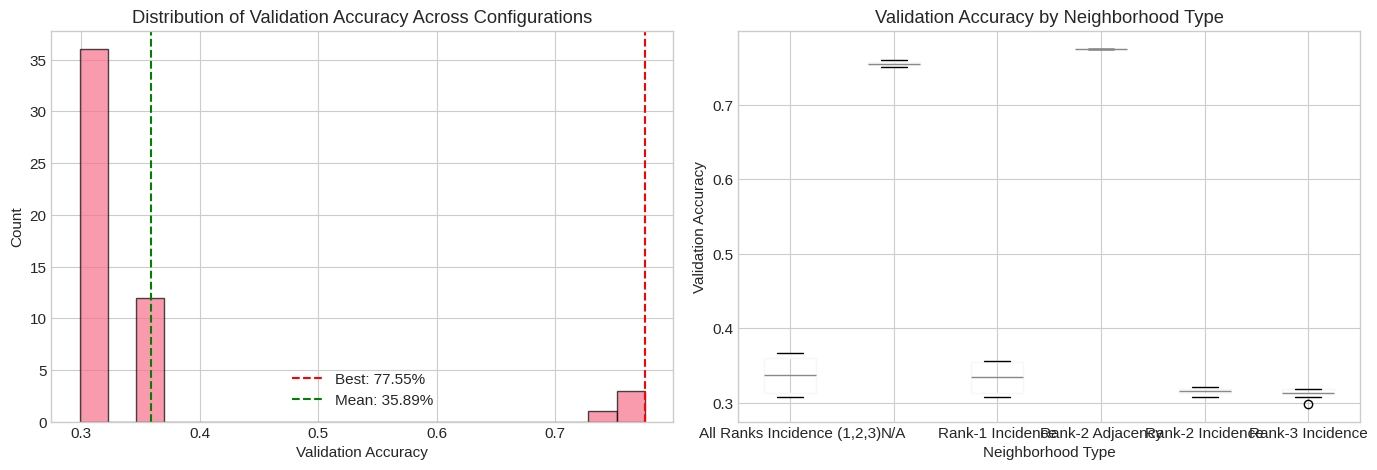

In [14]:
# Distribution of validation accuracies
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(agg_df['val_accuracy_mean'], bins=20, edgecolor='black', alpha=0.7)
axes[0].axvline(agg_df['val_accuracy_mean'].max(), color='red', linestyle='--', 
                label=f"Best: {agg_df['val_accuracy_mean'].max()*100:.2f}%")
axes[0].axvline(agg_df['val_accuracy_mean'].mean(), color='green', linestyle='--',
                label=f"Mean: {agg_df['val_accuracy_mean'].mean()*100:.2f}%")
axes[0].set_xlabel('Validation Accuracy')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Validation Accuracy Across Configurations')
axes[0].legend()

# Box plot by neighborhood type
agg_df.boxplot(column='val_accuracy_mean', by='neighborhood_type', ax=axes[1])
axes[1].set_xlabel('Neighborhood Type')
axes[1].set_ylabel('Validation Accuracy')
axes[1].set_title('Validation Accuracy by Neighborhood Type')
plt.suptitle('')

plt.tight_layout()
plt.show()

## 4. Ablation Studies

### 4.1 Neighborhoods Analysis (Special Focus)

The `model.backbone.neighborhoods` parameter defines which hyperedge types are used during learning. We are now using **up_adjacency** patterns:

- **Rank-1 Adjacency** (`[1-up_adjacency-0]`): Uses adjacency at rank 1 (edges)
- **Rank-2 Adjacency** (`[2-up_adjacency-0]`): Uses adjacency at rank 2 (triangles/triples)
- **Rank-3 Adjacency** (`[3-up_adjacency-0]`): Uses adjacency at rank 3 (tetrahedra/quadruples)
- **All Ranks (1,2,3)**: Combines all three adjacency types

In [15]:
# Neighborhood analysis
neigh_stats = agg_df.groupby('neighborhood_type').agg(
    mean_accuracy=('val_accuracy_mean', 'mean'),
    std_accuracy=('val_accuracy_mean', 'std'),
    max_accuracy=('val_accuracy_mean', 'max'),
    min_accuracy=('val_accuracy_mean', 'min'),
    count=('val_accuracy_mean', 'count')
).sort_values('mean_accuracy', ascending=False)

print("\n📊 NEIGHBORHOOD TYPE ANALYSIS 📊")
print("="*80)
for idx, row in neigh_stats.iterrows():
    print(f"\n{idx}:")
    print(f"  Mean Accuracy: {row['mean_accuracy']*100:.2f}% ± {row['std_accuracy']*100:.2f}%")
    print(f"  Best Accuracy: {row['max_accuracy']*100:.2f}%")
    print(f"  Worst Accuracy: {row['min_accuracy']*100:.2f}%")
    print(f"  Number of configs: {int(row['count'])}")


📊 NEIGHBORHOOD TYPE ANALYSIS 📊

Rank-2 Adjacency:
  Mean Accuracy: 77.53% ± 0.04%
  Best Accuracy: 77.55%
  Worst Accuracy: 77.50%
  Number of configs: 2

N/A:
  Mean Accuracy: 75.53% ± 0.66%
  Best Accuracy: 76.00%
  Worst Accuracy: 75.07%
  Number of configs: 2

All Ranks Incidence (1,2,3):
  Mean Accuracy: 33.68% ± 2.57%
  Best Accuracy: 36.68%
  Worst Accuracy: 30.80%
  Number of configs: 12

Rank-1 Incidence:
  Mean Accuracy: 33.37% ± 2.27%
  Best Accuracy: 35.64%
  Worst Accuracy: 30.80%
  Number of configs: 12

Rank-2 Incidence:
  Mean Accuracy: 31.59% ± 0.47%
  Best Accuracy: 32.18%
  Worst Accuracy: 30.80%
  Number of configs: 12

Rank-3 Incidence:
  Mean Accuracy: 31.36% ± 0.57%
  Best Accuracy: 31.88%
  Worst Accuracy: 29.88%
  Number of configs: 12


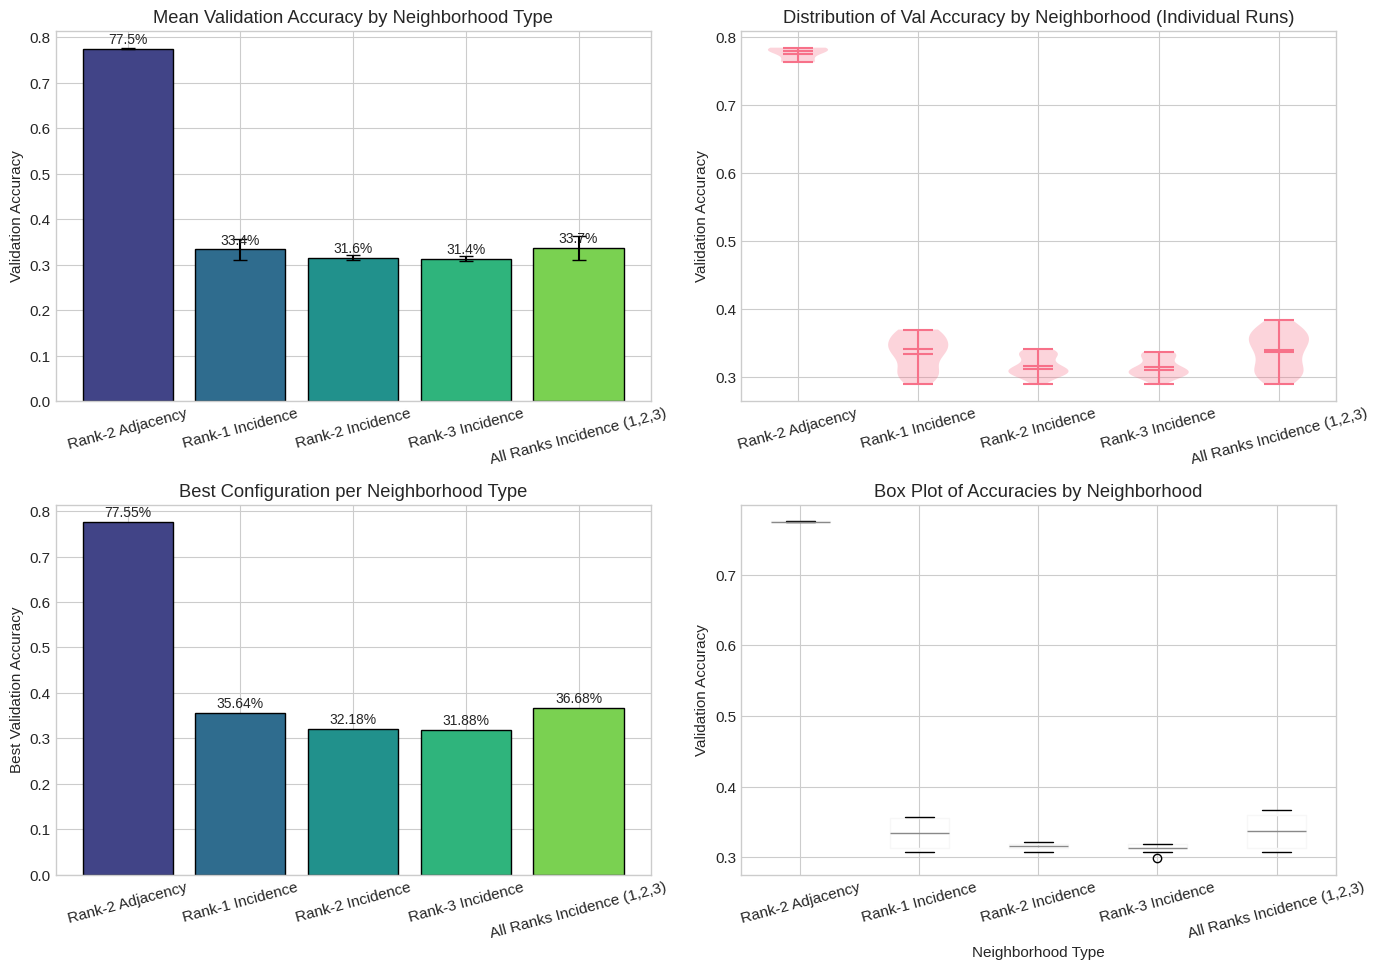

In [16]:
# Detailed neighborhood visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Define order for new adjacency-based neighborhoods
neigh_order = ['Rank-1 Adjacency', 'Rank-2 Adjacency', 'Rank-3 Adjacency', 'All Ranks Adjacency (1,2,3)', 'Rank-1 Incidence', 'Rank-2 Incidence', 'Rank-3 Incidence', 'All Ranks Incidence (1,2,3)']
neigh_order = [n for n in neigh_order if n in agg_df['neighborhood_type'].unique()]

# If no adjacency types found, try incidence types (backward compatibility)
if len(neigh_order) == 0:
    neigh_order = ['Rank-1 Incidence', 'Rank-2 Incidence', 'Rank-3 Incidence', 'All Ranks Incidence (1,2,3)']
    neigh_order = [n for n in neigh_order if n in agg_df['neighborhood_type'].unique()]

means = [agg_df[agg_df['neighborhood_type'] == n]['val_accuracy_mean'].mean() for n in neigh_order]
stds = [agg_df[agg_df['neighborhood_type'] == n]['val_accuracy_mean'].std() for n in neigh_order]

colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(neigh_order)))
bars = axes[0, 0].bar(neigh_order, means, yerr=stds, capsize=5, color=colors, edgecolor='black')
axes[0, 0].set_ylabel('Validation Accuracy')
axes[0, 0].set_title('Mean Validation Accuracy by Neighborhood Type')
axes[0, 0].tick_params(axis='x', rotation=15)

# Add value labels
for bar, mean in zip(bars, means):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
                    f'{mean*100:.1f}%', ha='center', va='bottom', fontsize=10)

# 2. Violin plot
neighborhood_data = [df[df['neighborhood_type'] == n]['val_accuracy'].values for n in neigh_order]
parts = axes[0, 1].violinplot(neighborhood_data, showmeans=True, showmedians=True)
axes[0, 1].set_xticks(range(1, len(neigh_order) + 1))
axes[0, 1].set_xticklabels(neigh_order, rotation=15)
axes[0, 1].set_ylabel('Validation Accuracy')
axes[0, 1].set_title('Distribution of Val Accuracy by Neighborhood (Individual Runs)')

# 3. Best accuracy per neighborhood
best_per_neigh = agg_df.loc[agg_df.groupby('neighborhood_type')['val_accuracy_mean'].idxmax()]
best_per_neigh = best_per_neigh.set_index('neighborhood_type').loc[neigh_order].reset_index()

bars = axes[1, 0].bar(best_per_neigh['neighborhood_type'], best_per_neigh['val_accuracy_mean'], 
                       color=colors, edgecolor='black')
axes[1, 0].set_ylabel('Best Validation Accuracy')
axes[1, 0].set_title('Best Configuration per Neighborhood Type')
axes[1, 0].tick_params(axis='x', rotation=15)

for bar, val in zip(bars, best_per_neigh['val_accuracy_mean']):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
                    f'{val*100:.2f}%', ha='center', va='bottom', fontsize=10)

# 4. Box plot comparison
agg_df_plot = agg_df[agg_df['neighborhood_type'].isin(neigh_order)].copy()
agg_df_plot['neighborhood_type'] = pd.Categorical(agg_df_plot['neighborhood_type'], categories=neigh_order, ordered=True)
agg_df_plot.boxplot(column='val_accuracy_mean', by='neighborhood_type', ax=axes[1, 1])
axes[1, 1].set_xlabel('Neighborhood Type')
axes[1, 1].set_ylabel('Validation Accuracy')
axes[1, 1].set_title('Box Plot of Accuracies by Neighborhood')
axes[1, 1].tick_params(axis='x', rotation=15)
plt.suptitle('')

plt.tight_layout()
plt.show()

In [17]:
# Statistical significance test between neighborhoods
from scipy import stats

print("\n📈 STATISTICAL COMPARISON BETWEEN NEIGHBORHOOD TYPES 📈")
print("="*80)
print("\nPairwise Mann-Whitney U tests (significance levels: * p<0.05, ** p<0.01, *** p<0.001):")

neigh_types = df['neighborhood_type'].unique()
results = []
for i, n1 in enumerate(neigh_types):
    for n2 in neigh_types[i+1:]:
        group1 = df[df['neighborhood_type'] == n1]['val_accuracy']
        group2 = df[df['neighborhood_type'] == n2]['val_accuracy']
        
        if len(group1) > 0 and len(group2) > 0:
            stat, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')
            significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
            results.append((n1, n2, p_value, significance))
            print(f"  {n1} vs {n2}: p={p_value:.4f} {significance}")

# Summary table
print("\nSummary: Neighborhood rankings by mean accuracy:")
for rank, (idx, row) in enumerate(neigh_stats.iterrows(), 1):
    print(f"  {rank}. {idx}: {row['mean_accuracy']*100:.2f}%")


📈 STATISTICAL COMPARISON BETWEEN NEIGHBORHOOD TYPES 📈

Pairwise Mann-Whitney U tests (significance levels: * p<0.05, ** p<0.01, *** p<0.001):
  All Ranks Incidence (1,2,3) vs Rank-2 Incidence: p=0.0022 **
  All Ranks Incidence (1,2,3) vs Rank-3 Incidence: p=0.0008 ***
  All Ranks Incidence (1,2,3) vs Rank-1 Incidence: p=0.5228 
  All Ranks Incidence (1,2,3) vs Rank-2 Adjacency: p=0.0001 ***
  All Ranks Incidence (1,2,3) vs N/A: p=0.0013 **
  Rank-2 Incidence vs Rank-3 Incidence: p=0.5378 
  Rank-2 Incidence vs Rank-1 Incidence: p=0.0027 **
  Rank-2 Incidence vs Rank-2 Adjacency: p=0.0001 ***
  Rank-2 Incidence vs N/A: p=0.0013 **
  Rank-3 Incidence vs Rank-1 Incidence: p=0.0012 **
  Rank-3 Incidence vs Rank-2 Adjacency: p=0.0001 ***
  Rank-3 Incidence vs N/A: p=0.0012 **
  Rank-1 Incidence vs Rank-2 Adjacency: p=0.0001 ***
  Rank-1 Incidence vs N/A: p=0.0013 **
  Rank-2 Adjacency vs N/A: p=0.0381 *

Summary: Neighborhood rankings by mean accuracy:
  1. Rank-2 Adjacency: 77.53%
  2. N/

### 4.2 Feature Encoder: out_channels

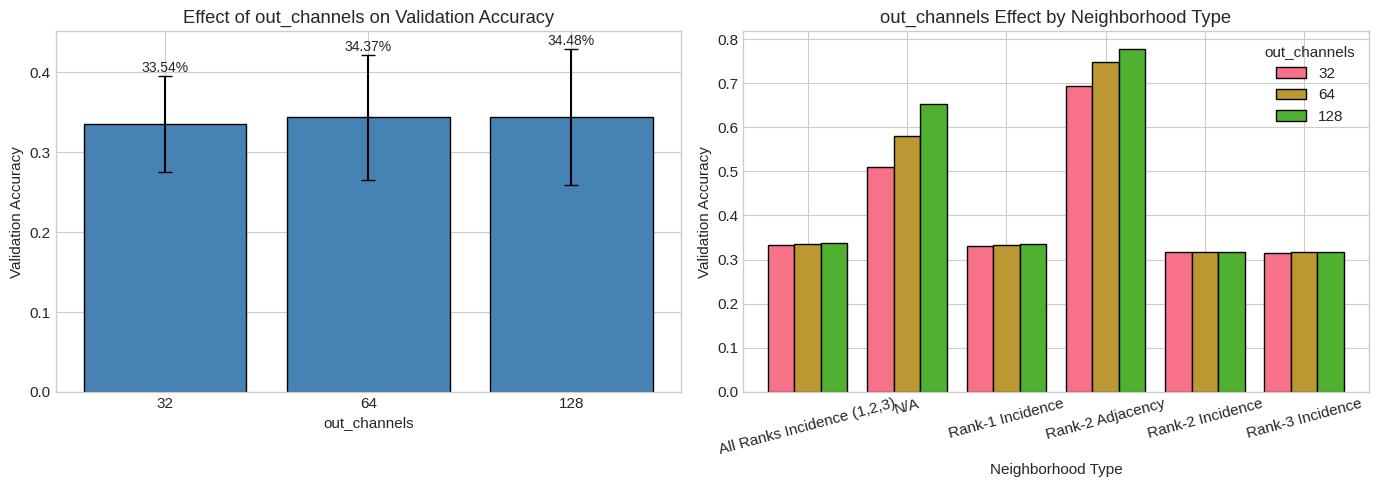


out_channels Statistics:
                  mean       std  count
out_channels                           
32            0.335385  0.059819    200
64            0.343723  0.077875    204
128           0.344769  0.085285    202


In [13]:
# Out channels analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall effect
out_ch_stats = agg_df.groupby('out_channels')['val_accuracy_mean'].agg(['mean', 'std', 'count'])
out_ch_stats = out_ch_stats.sort_index()

axes[0].bar(out_ch_stats.index.astype(str), out_ch_stats['mean'], 
            yerr=out_ch_stats['std'], capsize=5, color='steelblue', edgecolor='black')
axes[0].set_xlabel('out_channels')
axes[0].set_ylabel('Validation Accuracy')
axes[0].set_title('Effect of out_channels on Validation Accuracy')

for i, (idx, row) in enumerate(out_ch_stats.iterrows()):
    axes[0].text(i, row['mean'] + row['std'] + 0.005, f'{row["mean"]*100:.2f}%', 
                 ha='center', fontsize=10)

# Interaction with neighborhoods
pivot = agg_df.pivot_table(values='val_accuracy_mean', index='neighborhood_type', 
                           columns='out_channels', aggfunc='mean')
pivot.plot(kind='bar', ax=axes[1], edgecolor='black', width=0.8)
axes[1].set_xlabel('Neighborhood Type')
axes[1].set_ylabel('Validation Accuracy')
axes[1].set_title('out_channels Effect by Neighborhood Type')
axes[1].tick_params(axis='x', rotation=15)
axes[1].legend(title='out_channels')

plt.tight_layout()
plt.show()

print("\nout_channels Statistics:")
print(out_ch_stats.to_string())

### 4.3 Feature Encoder: proj_dropout

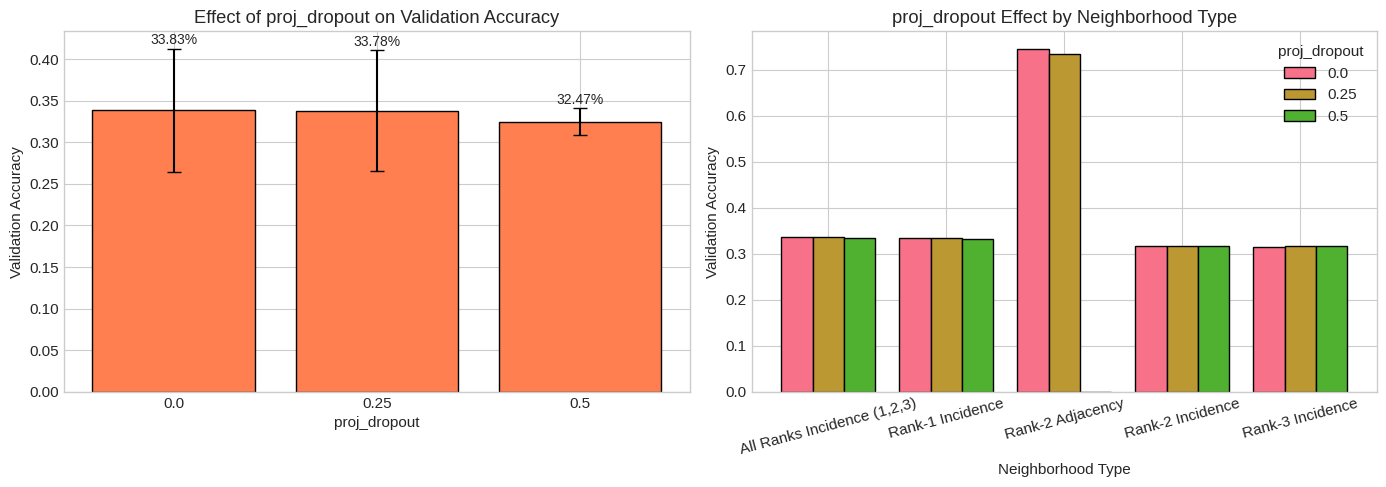


proj_dropout Statistics:
                  mean       std  count
proj_dropout                           
0.00          0.338305  0.074382    198
0.25          0.337849  0.072522    198
0.50          0.324750  0.015964    192


In [15]:
# Dropout analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall effect
dropout_stats = agg_df.groupby('proj_dropout')['val_accuracy_mean'].agg(['mean', 'std', 'count'])
dropout_stats = dropout_stats.sort_index()

axes[0].bar(dropout_stats.index.astype(str), dropout_stats['mean'], 
            yerr=dropout_stats['std'], capsize=5, color='coral', edgecolor='black')
axes[0].set_xlabel('proj_dropout')
axes[0].set_ylabel('Validation Accuracy')
axes[0].set_title('Effect of proj_dropout on Validation Accuracy')

for i, (idx, row) in enumerate(dropout_stats.iterrows()):
    axes[0].text(i, row['mean'] + row['std'] + 0.005, f'{row["mean"]*100:.2f}%', 
                 ha='center', fontsize=10)

# Interaction with neighborhoods
pivot = agg_df.pivot_table(values='val_accuracy_mean', index='neighborhood_type', 
                           columns='proj_dropout', aggfunc='mean')
pivot.plot(kind='bar', ax=axes[1], edgecolor='black', width=0.8)
axes[1].set_xlabel('Neighborhood Type')
axes[1].set_ylabel('Validation Accuracy')
axes[1].set_title('proj_dropout Effect by Neighborhood Type')
axes[1].tick_params(axis='x', rotation=15)
axes[1].legend(title='proj_dropout')

plt.tight_layout()
plt.show()

print("\nproj_dropout Statistics:")
print(dropout_stats.to_string())

### 4.4 Readout: Signal Propagation

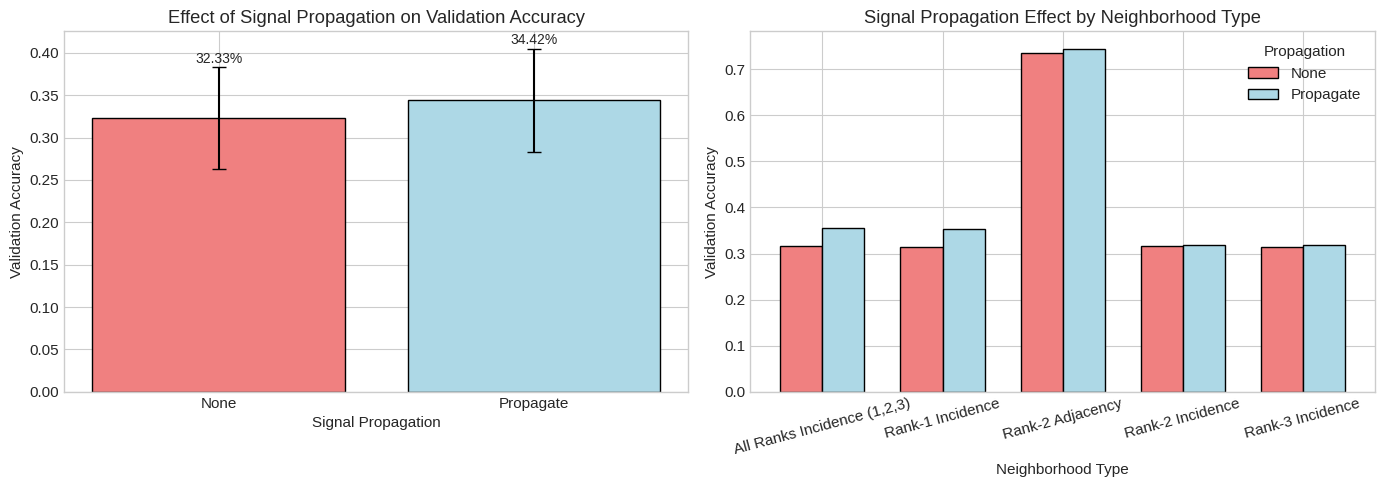


Signal Propagation Statistics:
                 mean       std  count
propagation                           
None         0.323282  0.059838    294
Propagate    0.344169  0.060838    294


In [16]:
# Signal propagation analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall effect
prop_stats = agg_df.groupby('propagation')['val_accuracy_mean'].agg(['mean', 'std', 'count'])

colors = ['lightcoral', 'lightblue']
axes[0].bar(prop_stats.index, prop_stats['mean'], yerr=prop_stats['std'], 
            capsize=5, color=colors, edgecolor='black')
axes[0].set_xlabel('Signal Propagation')
axes[0].set_ylabel('Validation Accuracy')
axes[0].set_title('Effect of Signal Propagation on Validation Accuracy')

for i, (idx, row) in enumerate(prop_stats.iterrows()):
    axes[0].text(i, row['mean'] + row['std'] + 0.005, f'{row["mean"]*100:.2f}%', 
                 ha='center', fontsize=10)

# Interaction with neighborhoods
pivot = agg_df.pivot_table(values='val_accuracy_mean', index='neighborhood_type', 
                           columns='propagation', aggfunc='mean')
pivot.plot(kind='bar', ax=axes[1], edgecolor='black', width=0.7, color=colors)
axes[1].set_xlabel('Neighborhood Type')
axes[1].set_ylabel('Validation Accuracy')
axes[1].set_title('Signal Propagation Effect by Neighborhood Type')
axes[1].tick_params(axis='x', rotation=15)
axes[1].legend(title='Propagation')

plt.tight_layout()
plt.show()

print("\nSignal Propagation Statistics:")
print(prop_stats.to_string())

## 5. Interaction Effects & Heatmaps

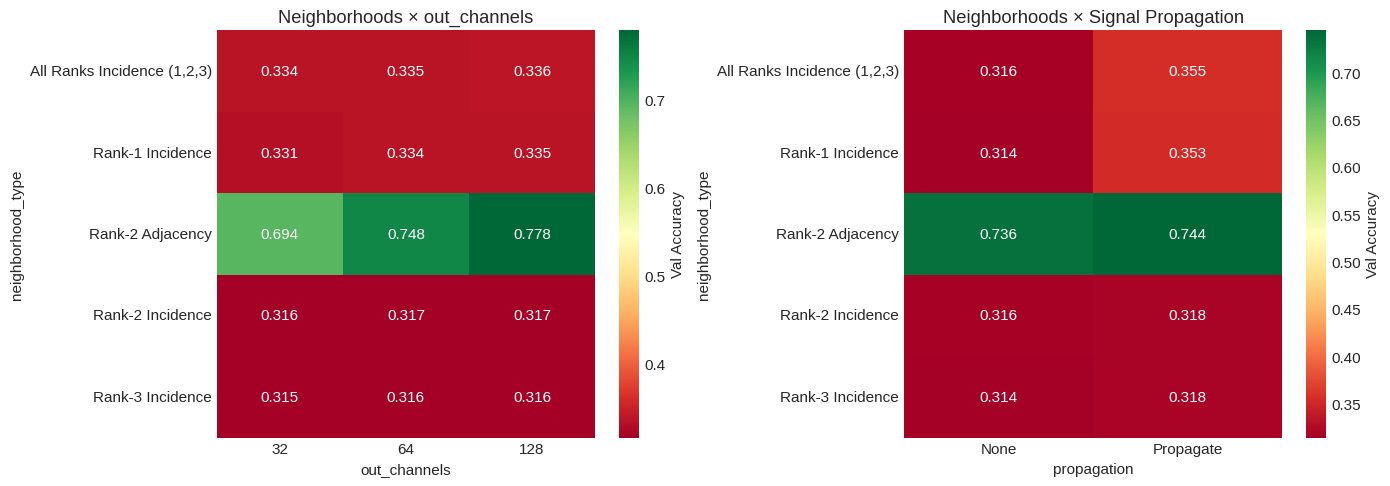

In [17]:
# Heatmap: neighborhoods vs other hyperparameters
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Neighborhoods x out_channels
pivot1 = agg_df.pivot_table(values='val_accuracy_mean', index='neighborhood_type', 
                            columns='out_channels', aggfunc='mean')
sns.heatmap(pivot1, annot=True, fmt='.3f', cmap='RdYlGn', ax=axes[0], cbar_kws={'label': 'Val Accuracy'})
axes[0].set_title('Neighborhoods × out_channels')

# 2. Neighborhoods x propagation
pivot2 = agg_df.pivot_table(values='val_accuracy_mean', index='neighborhood_type', 
                            columns='propagation', aggfunc='mean')
sns.heatmap(pivot2, annot=True, fmt='.3f', cmap='RdYlGn', ax=axes[1], cbar_kws={'label': 'Val Accuracy'})
axes[1].set_title('Neighborhoods × Signal Propagation')

plt.tight_layout()
plt.show()

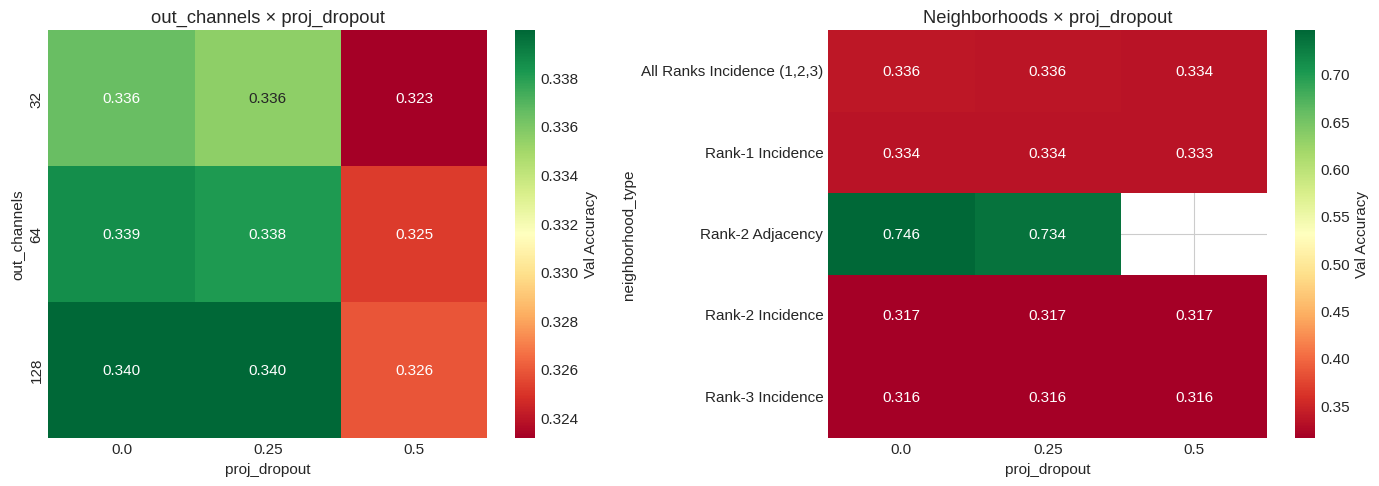

In [18]:
# Additional interaction heatmaps
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. out_channels x proj_dropout
pivot1 = agg_df.pivot_table(values='val_accuracy_mean', index='out_channels', 
                            columns='proj_dropout', aggfunc='mean')
sns.heatmap(pivot1, annot=True, fmt='.3f', cmap='RdYlGn', ax=axes[0], cbar_kws={'label': 'Val Accuracy'})
axes[0].set_title('out_channels × proj_dropout')

# 2. Neighborhoods x proj_dropout
pivot2 = agg_df.pivot_table(values='val_accuracy_mean', index='neighborhood_type', 
                            columns='proj_dropout', aggfunc='mean')
sns.heatmap(pivot2, annot=True, fmt='.3f', cmap='RdYlGn', ax=axes[1], cbar_kws={'label': 'Val Accuracy'})
axes[1].set_title('Neighborhoods × proj_dropout')

plt.tight_layout()
plt.show()

In [19]:
# Best hyperparameters per neighborhood type
print("\n🎯 BEST HYPERPARAMETERS PER NEIGHBORHOOD TYPE 🎯")
print("="*100)

for neigh in neigh_order:
    neigh_df = agg_df[agg_df['neighborhood_type'] == neigh]
    if len(neigh_df) > 0:
        best = neigh_df.loc[neigh_df['val_accuracy_mean'].idxmax()]
        print(f"\n{neigh}:")
        print(f"  Best Val Accuracy: {best['val_accuracy_mean']*100:.2f}% ± {best['val_accuracy_std']*100:.2f}%")
        print(f"  out_channels: {best['out_channels']}")
        print(f"  proj_dropout: {best['proj_dropout']}")
        print(f"  activation: {best['activation']}")
        print(f"  pooling_type: {best['pooling_type']}")
        print(f"  propagation: {best['propagation']}")
        print(f"  weight_decay: {best['weight_decay']}")


🎯 BEST HYPERPARAMETERS PER NEIGHBORHOOD TYPE 🎯

Rank-2 Adjacency:
  Best Val Accuracy: 78.56% ± 0.97%
  out_channels: 128
  proj_dropout: 0.25
  activation: relu
  pooling_type: mean
  propagation: Propagate
  weight_decay: 0.0

Rank-1 Incidence:
  Best Val Accuracy: 35.63% ± 1.33%
  out_channels: 128
  proj_dropout: 0.5
  activation: relu
  pooling_type: mean
  propagation: Propagate
  weight_decay: 0.0005

Rank-2 Incidence:
  Best Val Accuracy: 31.86% ± 1.59%
  out_channels: 128
  proj_dropout: 0.0
  activation: relu
  pooling_type: mean
  propagation: Propagate
  weight_decay: 0.0

Rank-3 Incidence:
  Best Val Accuracy: 31.89% ± 1.67%
  out_channels: 64
  proj_dropout: 0.25
  activation: relu
  pooling_type: mean
  propagation: Propagate
  weight_decay: 0.0

All Ranks Incidence (1,2,3):
  Best Val Accuracy: 35.87% ± 1.32%
  out_channels: 128
  proj_dropout: 0.25
  activation: relu
  pooling_type: mean
  propagation: Propagate
  weight_decay: 0.0


## 6. Hyperparameter Importance Ranking

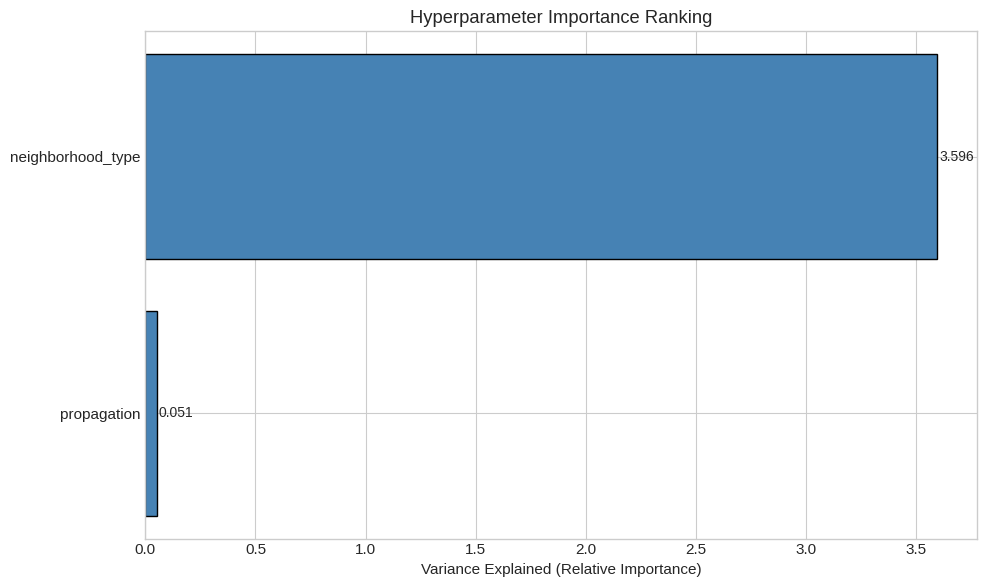


📊 HYPERPARAMETER IMPORTANCE RANKING 📊
1. neighborhood_type: 3.5964
2. propagation: 0.0511


In [18]:
# Calculate variance explained by each hyperparameter
def calc_variance_explained(df, groupby_col, target_col='val_accuracy_mean'):
    """Calculate the variance explained by a hyperparameter."""
    total_var = df[target_col].var()
    between_var = df.groupby(groupby_col)[target_col].mean().var()
    return between_var / total_var if total_var > 0 else 0

# Only analyze hyperparameters with multiple values
hyperparams = ['neighborhood_type', 'out_channels', 'proj_dropout', 'propagation']

importance = {}
for hp in hyperparams:
    if agg_df[hp].nunique() > 1:  # Only if there's variation
        importance[hp] = calc_variance_explained(agg_df, hp)

if len(importance) > 0:
    # Sort by importance
    importance_sorted = dict(sorted(importance.items(), key=lambda x: x[1], reverse=True))

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.barh(list(importance_sorted.keys()), list(importance_sorted.values()), 
                   color='steelblue', edgecolor='black')
    ax.set_xlabel('Variance Explained (Relative Importance)')
    ax.set_title('Hyperparameter Importance Ranking')
    ax.invert_yaxis()

    # Add value labels
    for bar, val in zip(bars, importance_sorted.values()):
        ax.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.3f}', 
                va='center', fontsize=10)

    plt.tight_layout()
    plt.show()

    print("\n📊 HYPERPARAMETER IMPORTANCE RANKING 📊")
    print("="*50)
    for rank, (hp, imp) in enumerate(importance_sorted.items(), 1):
        print(f"{rank}. {hp}: {imp:.4f}")
else:
    print("Not enough variation in hyperparameters to compute importance.")

## 7. Validation vs Test Accuracy Comparison

In [19]:
# Check correlation between validation and test accuracy
valid_test_df = agg_df[agg_df['test_accuracy_mean'].notna()].copy()

if len(valid_test_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Color map for adjacency-based neighborhoods
    color_map = {
        'Rank-1 Adjacency': 'red',
        'Rank-2 Adjacency': 'blue',
        'Rank-3 Adjacency': 'green',
        'All Ranks (1,2,3)': 'purple',
        # Backward compatibility
        'Rank-1 Incidence': 'red',
        'Rank-2 Incidence': 'blue',
        'Rank-3 Incidence': 'green',
    }
    colors = valid_test_df['neighborhood_type'].map(color_map).fillna('gray')
    
    axes[0].scatter(valid_test_df['val_accuracy_mean'], valid_test_df['test_accuracy_mean'], 
                    c=colors, alpha=0.7, s=60)
    
    # Add ideal line
    min_val = min(valid_test_df['val_accuracy_mean'].min(), valid_test_df['test_accuracy_mean'].min())
    max_val = max(valid_test_df['val_accuracy_mean'].max(), valid_test_df['test_accuracy_mean'].max())
    axes[0].plot([min_val, max_val], [min_val, max_val], 'k--', label='Ideal (y=x)')
    
    # Add correlation
    corr = valid_test_df['val_accuracy_mean'].corr(valid_test_df['test_accuracy_mean'])
    axes[0].set_xlabel('Validation Accuracy')
    axes[0].set_ylabel('Test Accuracy')
    axes[0].set_title(f'Validation vs Test Accuracy (r = {corr:.3f})')
    
    # Add legend for colors
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=c, label=n) for n, c in color_map.items() if n in valid_test_df['neighborhood_type'].values]
    axes[0].legend(handles=legend_elements, loc='lower right')
    
    # Generalization gap analysis
    valid_test_df['gap'] = valid_test_df['val_accuracy_mean'] - valid_test_df['test_accuracy_mean']
    
    gap_by_neigh = valid_test_df.groupby('neighborhood_type')['gap'].agg(['mean', 'std'])
    gap_by_neigh.plot(kind='bar', y='mean', yerr='std', ax=axes[1], capsize=5, 
                      color='coral', edgecolor='black', legend=False)
    axes[1].set_xlabel('Neighborhood Type')
    axes[1].set_ylabel('Generalization Gap (Val - Test)')
    axes[1].set_title('Generalization Gap by Neighborhood Type')
    axes[1].tick_params(axis='x', rotation=15)
    axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nCorrelation between validation and test accuracy: {corr:.3f}")
    print(f"Mean generalization gap: {valid_test_df['gap'].mean()*100:.2f}%")
else:
    print("No test accuracy data available for comparison.")

No test accuracy data available for comparison.


## 8. Summary & Conclusions

In [20]:
# Generate summary report
print("="*100)
print("                    MAGA TOPOTUNE HYPERGRAPH - GRID SEARCH ANALYSIS SUMMARY")
print("="*100)

print(f"\n📊 OVERALL STATISTICS:")
print(f"   Total configurations analyzed: {len(agg_df)}")
print(f"   Total individual runs: {len(df)}")
print(f"   Seeds used: {sorted(df['data_seed'].unique())}")

print(f"\n🏆 BEST OVERALL CONFIGURATION:")
best_overall = agg_df.loc[agg_df['val_accuracy_mean'].idxmax()]
print(f"   Validation Accuracy: {best_overall['val_accuracy_mean']*100:.2f}% ± {best_overall['val_accuracy_std']*100:.2f}%")
print(f"   Neighborhood: {best_overall['neighborhood_type']}")
print(f"   out_channels: {best_overall['out_channels']}")
print(f"   proj_dropout: {best_overall['proj_dropout']}")
print(f"   activation: {best_overall['activation']}")
print(f"   pooling_type: {best_overall['pooling_type']}")
print(f"   propagation: {best_overall['propagation']}")
print(f"   weight_decay: {best_overall['weight_decay']}")

print(f"\n📈 KEY FINDINGS:")

# Find best neighborhood
best_neigh = neigh_stats.index[0]
best_neigh_acc = neigh_stats.loc[best_neigh, 'mean_accuracy']
print(f"\n   1. NEIGHBORHOOD TYPE (Most Important):")
print(f"      Best: {best_neigh} (mean acc: {best_neigh_acc*100:.2f}%)")
print(f"      Rankings:")
for rank, (idx, row) in enumerate(neigh_stats.iterrows(), 1):
    print(f"         {rank}. {idx}: {row['mean_accuracy']*100:.2f}%")

# Other findings based on the data
if len(importance) > 0:
    print(f"\n   2. HYPERPARAMETER IMPORTANCE (by variance explained):")
    for i, (hp, imp) in enumerate(list(importance_sorted.items())[:5], 1):
        print(f"      {i}. {hp}: {imp:.4f}")

print("\n" + "="*100)

                    MAGA TOPOTUNE HYPERGRAPH - GRID SEARCH ANALYSIS SUMMARY

📊 OVERALL STATISTICS:
   Total configurations analyzed: 52
   Total individual runs: 152
   Seeds used: [np.int64(1), np.int64(3), np.int64(5)]

🏆 BEST OVERALL CONFIGURATION:
   Validation Accuracy: 77.55% ± 1.11%
   Neighborhood: Rank-2 Adjacency
   out_channels: 128
   proj_dropout: 0.25
   activation: relu
   pooling_type: mean
   propagation: None
   weight_decay: 0

📈 KEY FINDINGS:

   1. NEIGHBORHOOD TYPE (Most Important):
      Best: Rank-2 Adjacency (mean acc: 77.53%)
      Rankings:
         1. Rank-2 Adjacency: 77.53%
         2. N/A: 75.53%
         3. All Ranks Incidence (1,2,3): 33.68%
         4. Rank-1 Incidence: 33.37%
         5. Rank-2 Incidence: 31.59%
         6. Rank-3 Incidence: 31.36%

   2. HYPERPARAMETER IMPORTANCE (by variance explained):
      1. neighborhood_type: 3.5964
      2. propagation: 0.0511



In [ ]:
# Export aggregated results to CSV for further analysis
output_path = 'hyperparameter_analysis_results.csv'
agg_df.to_csv(output_path, index=False)
print(f"Results exported to '{output_path}'")

# Also export the raw data
raw_output_path = 'hyperparameter_analysis_raw.csv'
df.to_csv(raw_output_path, index=False)
print(f"Raw data exported to '{raw_output_path}'")